Let start by importing necessary package 

In [87]:
using Pkg
Pkg.activate(".")

  Activating project at `c:\Users\uiv02757\OneDrive - Vitesco Technologies\git_repos\preconditioning`


In [88]:
using OptimalControl
using Plots
using ForwardDiff
using DifferentialEquations
using MINPACK
using FitEllipse

We consider the following optimal control problem 


$$
    \left\{ \begin{array}{ll}
    \displaystyle \min_{x,u} \int_{0}^{t_f} x(t) ~\mathrm dt \\[1em]
    \text{s.c.}~\dot x(t) = u(t), & t\in [0, t_f]~\mathrm{a.e.}, \\[0.5em]
    \phantom{\mathrm{s.c.}~} u(t) \in [-1,1], & t\in [0, t_f], \\[0.5em]
    \phantom{\mathrm{s.c.}~} x(t_0) = 0, \quad x(t_f) = x_f,
    \end{array} \right.
$$
with $x_0 = 0$ and $t_f = 5$.

┌ Info: Saved animation to C:\Users\uiv02757\AppData\Local\Temp\jl_4BshSPsVq1.gif
└ @ Plots C:\Users\uiv02757\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\uiv02757\\AppData\\Local\\Temp\\jl_4BshSPsVq1.gif")
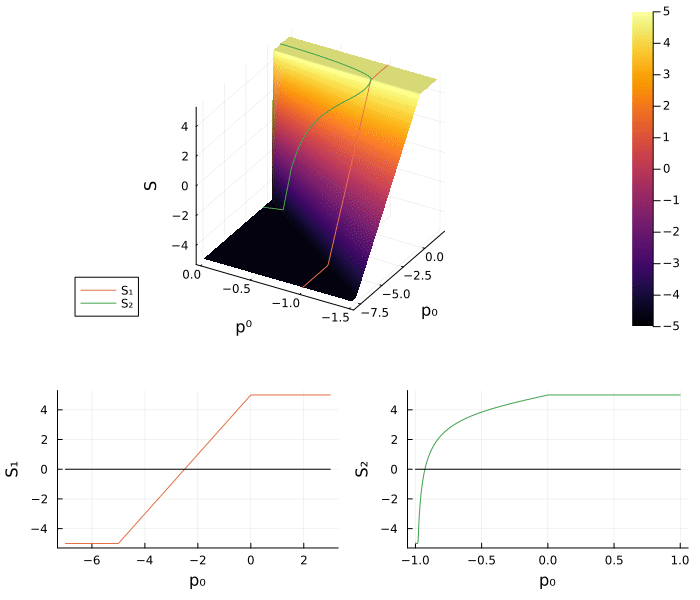

In [94]:
global α = 1

function condition(z, t, integrator)                        # event when condition(z,t,integrator) == 0
    x⁰,x,p⁰,p = z
    return p
end
function affect!(integrator)                                # action when condition == 0 
    global α = -α
    nothing
end

cb = ContinuousCallback(condition, affect!)                 # callback 
H(x, p) = p[1] * x[2] + α * p[2]
ϕ_ = Flow(Hamiltonian(H), callback = cb)                     # flow with maximizing control 

function ϕ(t0, x0, p0, tf; kwargs...)  
    if p0[2] == 0
        global α = -sign(p0[1])
    else
        global α = sign(p0[2])
    end
    return ϕ_(t0, x0, p0, tf; kwargs...)
end

function ϕ((t0, tf), x0, p0; kwargs...)                     # flow for plot
    if p0[2] == 0
        global α = -sign(p0[1])
    else
        global α = sign(p0[2])
    end
    return ϕ_((t0, tf), x0, p0; kwargs...)
end

t0 = 0; x0 = [0,0]; tf = 5; xT = 0;                         # final condition

π((x,p)) = x[2];                                            # projection on state space

ϕₓ(p0) = π( ϕ(t0, x0, p0, tf) )
η(p0) = -sqrt.(1 - p0.^2)
ϕₓ₁(p0) = ϕₓ([-1, p0])
ϕₓ₂(p0) = abs(p0) ≤ 1 ? ϕₓ([η(p0), p0]) : sign(p0)*tf

# Plot
plt_S1 = plot(range(-7, 3, 500), ϕₓ₁ , color = 2)
plot!([-7,3], [xT,xT], color = :black)
plot!(xlabel = "p₀", ylabel = "S₁", legend=false)

plt_S2 = plot(range(-1, 1, 500), ϕₓ₂, color = 3)
plot!([-1,1], [xT,xT], color = :black)
plot!(xlabel = "p₀", ylabel = "S₂", legend=false)

ϕₓ_(p⁰, p) = ϕₓ([p⁰, p])
plt_S = surface(range(0, -1.5, 100), range(-8, 2, 100), ϕₓ_, camera = (30,30))
surface!(xlabel = "p⁰", ylabel = "p₀", zlabel = "S", xflip = true)
plot3d!(-1*ones(100), range(-8, 2, 100), ϕₓ₁.(range(-8, 2, 100)), label = "S₁")
plot3d!(η.(range(-1, 1, 100)), range(-1, 1, 100), ϕₓ₂.(range(-1, 1, 100)), label = "S₂")

plt_S12 = plot(plt_S1, plt_S2, layout = (1,2))
plt_total = plot(plt_S, plt_S12, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

@gif for i ∈ [range(30, 90, 50); 90*ones(25); range(90, 30, 50); 30*ones(25)]
    plot!(plt_total[1], camera=(i,i), 
        zticks = i==90 ? false : true,
        zlabel = i==90 ? "" : "S" )
end

### Visualisation of the state flow

Evaluation on ξ : 3.8452994616207485
Jacobian on ξ : 3.0792014356780086
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.845299e+00     0.000000e+00         0.018000
     2     5.000000e+00     1.559496e+00         0.000000
     3     5.000000e+00     4.983094e-01         0.000000
     4     5.000000e+00     4.983094e-01         0.000000
     5     5.000000e+00     4.983094e-01         0.000000
     6     2.825589e+00     9.417471e-02         0.000000
     7     3.275582e+00     5.569993e-02         0.000000
     8     1.835694e+00     1.605481e-02         0.000000
     9     5.000000e+00     4.108358e-02         0.000000
    10     8.767661e-01     2.198078e-02         0.000000
    11     1.052824e+00     2.476848e-03         0.000000
    12     2.252319e-01     7.373618e-04         0.000000
    13     6.733089e-02     6.111140e-05         0.015000
    14     4.061534e-03     3.236777e-06         0.000000
    1

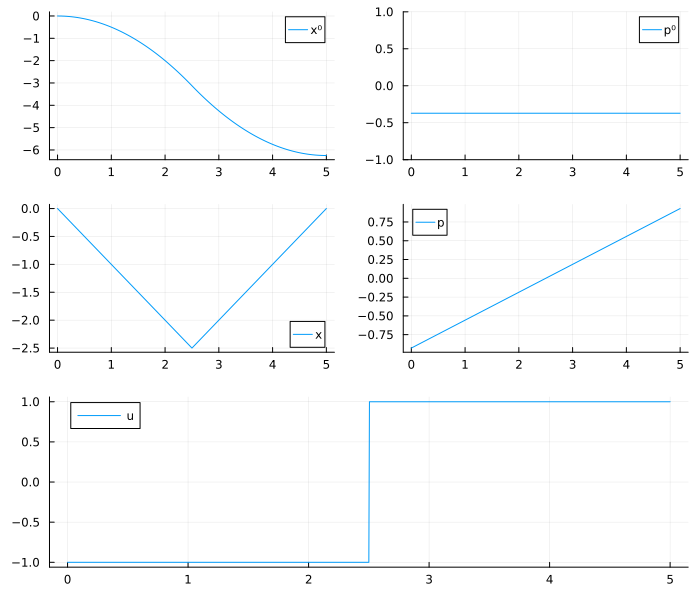

In [95]:
S(p0)  = ϕₓ(p0)  - xT;                                      # general shooting function
S₁(p0) = ϕₓ₁(p0) - xT;                                      # shooting function 1 
S₂(p0) = ϕₓ₂(p0) - xT;                                      # shooting function 2

S₁!(s₁, ξ) = (s₁[:] .= S₁(ξ[1]); nothing)                   # intermediate function
S₂!(s₂, ξ) = (s₂[:] .= S₂(ξ[1]); nothing)                   # intermediate function

jS₁(ξ) = ForwardDiff.jacobian(p0 -> [S₁(p0[1])], ξ)         # compute jacobian by forward differentiation
jS₂(ξ) = ForwardDiff.jacobian(p0 -> [S₂(p0[1])], ξ)         # compute jacobian by forward differentiation
jS₁!(js₁, ξ) = (js₁[:] .= jS₁(ξ); nothing)                  # intermediate function
jS₂!(js₂, ξ) = (js₂[:] .= jS₂(ξ); nothing)                  # intermediate function

ξ = [-0.5]                                                  # initial guess
println("Evaluation on ξ : ", S₂(ξ[1]))
println("Jacobian on ξ : ", jS₂(ξ)[1])

p0_sol = fsolve(S₂!, jS₂!, ξ, show_trace = true)            # solve
println(p0_sol)                                             # print solution
sol = ϕ((t0, tf), x0, [η(p0_sol.x[1]), p0_sol.x[1]], 
    saveat=range(t0, tf, 500))                              # get optimal trajectory

# plot
t = sol.t
x⁰ = [sol.u[i][1] for i in 1:length(sol.u)]
x  = [sol.u[i][2] for i in 1:length(sol.u)]
p⁰ = [sol.u[i][3] for i in 1:length(sol.u)]
p  = [sol.u[i][4] for i in 1:length(sol.u)]
u = sign.(p)

plt_x⁰ = plot(t, x⁰, label = "x⁰")
plt_x  = plot(t, x , label = "x" )
plt_p⁰ = plot(t, p⁰, label = "p⁰", ylim=[-1,1])
plt_p  = plot(t, p , label = "p" )
plt_u  = plot(t, u,  label = "u" )

plt_xp = plot(plt_x⁰, plt_p⁰, plt_x, plt_p, layout=(2, 2))
plot(plt_xp, plt_u, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

### Accessible set

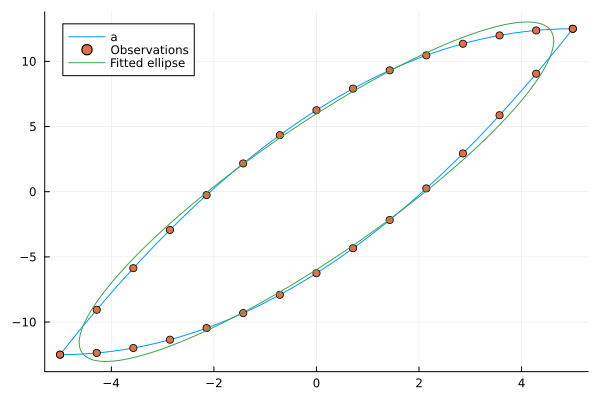

In [236]:
n = 15
n_ = 100
p0 = [[[-1, i] for i ∈ range(-tf, 0, n)];
      [[1, i] for i ∈ range(tf, 0, n)]]
p0_ = [[[-1, i] for i ∈ range(-tf, 0, n_)];
       [[1, i] for i ∈ range(tf, 0, n_)]]

x = zeros(2, 2*n); p = zeros(2,2*n) 
for i = 1:length(p0)
    x[:,i], p[:,i] = ϕ(t0, x0, p0[i], tf)
end
x_ = zeros(2, 2*n_); p_ = zeros(2, 2*n_)
for i = 1:length(p0_)
    x_[:,i], p_[:,i] = ϕ(t0, x0, p0_[i], tf)
end

a, b, θ, c₀, c₁, p = fit_ellipse(x[2,:], x[1,:])
xₑ, yₑ = ellipse_from_parametric(a, b, θ, x₀, y₀, 1000)

plot(x_[2,:],x_[1,:], label="a")
scatter!(x[2,:],x[1,:], label="Observations", legend=:topleft)
plot!(xₑ, yₑ, label = "Fitted ellipse")